In [3]:
# import libraries ต่าง ๆ ที่จะใช้
import torchviz
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # ใช้ในการแบ่งข้อมูล
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from torchmetrics.classification import MulticlassPrecisionRecallCurve
from torch.utils.data import WeightedRandomSampler
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold


In [4]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/2 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [5]:
# check ของแปลกที่หลุดเข้ามา
for x in df.columns:
    print(x)

Drug
Allele
ADR_MPexanthema
ADR_SJS
ADR_TEN
ADR
Cohort ethnicity_Black
Cohort ethnicity_Caucasian
Cohort ethnicity_Diverse
Cohort ethnicity_Mongol
Cohort ethnicity
No_ADR
Yes_ADR
0
1
2
3
4
11
20
23
30
74
80
86
122
123
130
140
151
162
175
191
204
207
245
248
264
294
297
300
314
315
319
323
333
336
338
350
352
366
371
378
381
389
405
409
426
428
435
448
456
461
469
470
485
486
501
502
511
527
530
535
547
554
556
561
588
600
609
623
624
631
637
650
656
675
679
694
713
715
725
739
745
750
751
764
770
772
780
787
794
798
806
807
833
834
843
849
872
875
882
883
884
888
926
935
952
974
984
987
990
993
1011
1017
1019
1028
1039
1043
1044
1055
1057
1060
1066
1070
1077
1088
1097
1098
1099
1102
1105
1114
1120
1130
1137
1138
1142
1145
1148
1152
1153
1155
1164
1168
1171
1182
1184
1199
1212
1236
1242
1267
1269
1270
1292
1295
1312
1313
1318
1325
1340
1347
1351
1357
1380
1389
1391
1398
1426
1428
1434
1446
1448
1449
1452
1457
1459
1464
1476
1480
1498
1528
1535
1542
1544
1564
1578
1585
1589
1602
1607
164

In [6]:
df['ADR'].value_counts()

SJS            5805
TEN            3738
MPexanthema    3530
Name: ADR, dtype: int64

In [7]:
# Drop unnecessary columns
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2})#,'MPeruption':3})
#df = df[df['ADR'].isin([0,1])] #ลบ MP ออก
#df_stratify['Yes_ADR'] = df['ADR'].copy()
#df_stratify = df_stratify.rename(columns={'Yes_ADR':'ADR'})
df.drop(columns=['No_ADR','ADR','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True) #'MPeruption' removed

In [9]:
# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    350
dtype: int64

In [12]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [ ]:
np_input

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [4]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

In [5]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()

In [6]:
# Define the model hyperparameters
classes = 1
batch_size = 128 
LEARNING_RATE = 2e-5 
DROPOUT_RATE = 0.2
L2lambda = 1e-2
EPOCHS = 1000
DIR = os.getcwd()
dirname = "optuna_study6(wide_final)" 
#train_loader, test_loader = get_dataloaders(batch_size)
loss_fn = nn.BCELoss() 
#get_dataloader_distribution(train_loader,test_loader)

In [7]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def define_model(trial):

    # Roughly optimize batch size 32, 64, 128
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024, 2048, 4096])
    batch_norm = trial.suggest_categorical("batch_norm",['yes','no'])
    dropout = trial.suggest_categorical("dropout",['yes','no'])
    global weightdecay
    weightdecay = trial.suggest_categorical("weightdecay",['yes','no'])
    global train_loader
    global test_loader
    train_loader, test_loader = get_dataloaders(batch_size)
    get_dataloader_distribution(train_loader,test_loader)


    # Optimize number of layer
    n_layers = trial.suggest_int("n_layers", 1,6) #อย่าลืมบวก 1 เพราะ append ไปก่อนเข้า loop แล้ว
    if dropout == 'yes':
        p = trial.suggest_float("dropout_l", 0.1, 0.4) 
    #p = DROPOUT_RATE
    layers = []

    in_features = train_loader.dataset.tensors[0].shape[1]
    #out_features = 256
    out_features = trial.suggest_categorical("n_first_units", [256,512,1024,2048, 4096])

    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    if dropout == 'yes':
        layers.append(nn.Dropout(p))
    
    in_features = out_features

    for i in range(n_layers): #i หมายถึงเลขชั้น hidden+1
        #out_features = trial.suggest_int("n_units_l{}".format(i), 5, 4096) 
        #out_features = trial.suggest_int("n_units_l{}".format(i), 256, 2048, 256) 
        if batch_norm == 'yes':
            layers.append(nn.BatchNorm1d(in_features))
        out_features = int(in_features/2)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        if dropout == 'yes':
            layers.append(nn.Dropout(p))
        in_features = out_features

    #layers.append(nn.Linear(in_features, 2048)) #เพิ่มเพ่อบังคับให้ layer สุดท้าย 2048 ตามผลของ optuna
    #layers.append(nn.ReLU()) 
    if batch_norm == 'yes':
        layers.append(nn.BatchNorm1d(in_features))                          
    layers.append(nn.Linear(out_features, classes)) 
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)
    
    print(model)
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"]) #ให้เลือกแค่ Adam อย่างเดียว ไม่ได้ลบไว้เพราะเผื่อจะใส่ SGD ให้ optuna ลองเลือก
    lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)
    #lr = LEARNING_RATE #ใช้ lr ที่ define ไว้ (ไม่ต้อง optimize)
    if weightdecay == 'yes':
        L2lambda = trial.suggest_float("L2lambda", 1e-3, 1e-1, log=True)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=L2lambda) #เพิ่ม weight decay เพื่อให้ model ไม่ overfit
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr) #เพิ่ม weight decay เพื่อให้ model ไม่ overfit
    #ใช้ L2lambda ที่ define ไว้ (ไม่ต้อง optimize)
    
    run_name = "trial-%d" % trial.number
    run_dir = os.path.join(dirname, run_name) # This is the dir used in tensorboard_callback of optuna

    # Tensorboard Integration
    #writer = SummaryWriter(log_dir = f"{run_dir}")
    
    # Training of the model.
    for epoch in range(EPOCHS):
        running_loss = []
        running_train_acc = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):



            data = data.float().to(device)
            target = target.float().to(device)

            #with torch.no_grad():
            if epoch == 0 and batch_idx == 0:
                dot = torchviz.make_dot(model(data), show_attrs=True, show_saved = True,params=dict(model.named_parameters()))
                #dot.format = "png"
                dot.render(f'{dirname}/{run_name}_model')

            optimizer.zero_grad()
            output = model(data)
            output = output.flatten()
            
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
    
            running_loss.append(loss.item()) 

            with torch.no_grad():
                target = target.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                train_acc = correct/len(target)
                train_acc = round(train_acc, 8)
                running_train_acc.append(train_acc)
        train_acc = np.mean(running_train_acc)
        train_loss = np.mean(running_loss)
        
        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):

                data = data.float().to(device)
                target = target.float().to(device)               
                output = model(data)
                output = output.flatten()
                #data = data.flatten()
                test_loss = loss_fn(output, target)
                output = torch.round(output)
                correct = (output == target).sum().item()
                
            test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)
            
            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
        
            test_loss = test_loss.cpu().detach().numpy()
   
            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)

        
        print(f"epoch{epoch}, train accuracy: {train_acc}, test accuracy:{test_acc} train loss:{round(train_loss,8)}, test loss:{round(test_loss.item(),8)}, test precision: {test_precision},test recall: {test_recall_score},test f1: {test_f1_score}")
        with tf.summary.create_file_writer(f"{run_dir}_train").as_default():
            tf.summary.scalar("loss", train_loss, step=epoch)
            tf.summary.scalar("acc", train_acc, step=epoch)
        with tf.summary.create_file_writer(f"{run_dir}_test").as_default():    
            tf.summary.scalar("loss", test_loss, step=epoch) 
            tf.summary.scalar("acc", test_acc, step=epoch)
            tf.summary.scalar("precision", test_precision, step=epoch)
            tf.summary.scalar("f1_score", test_f1_score, step=epoch)
            tf.summary.scalar("recall_score", test_recall_score, step=epoch)
            trial.report(test_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    #หากรันจบให้เซฟโมเดลเก็บไว้ด้วยจร้า
    torch.save(model.state_dict(),f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")
    model_tosave = torch.jit.script(model)
    model_tosave.save(f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")

    #Close Writer before openning again
    #writer.close()
    
    return train_loss

if __name__ == "__main__":
    tensorboard_callback = TensorBoardCallback(dirname = dirname, metric_name="target")
    pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3)
    study = optuna.create_study(study_name = dirname, directions=["minimize"],sampler=TPESampler(),storage='sqlite:///optuna.sqlite3',pruner=pruner, load_if_exists=True)
    study.optimize(objective, n_trials=19, timeout=None)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:175: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
[I 2023-04-18 09:57:13,859] Using an existing study with name 'optuna_study6(wide_final)' instead of creating a new one.
[W 2023-04-18 09:57:14,800] Trial 253 failed with parameters: {'batch_size': 64, 'batch_norm': 'no', 'dropout': 'yes', 'weightdecay': 'no'} because of the following error: NameError("name 'np_input' is not defined").
Traceback (most recent call last):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_32224\832558458.py", line 63, in objective
    model = define_model(trial).to(device)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_32224\832558458.py", line 17, in define_model
    

NameError: name 'np_input' is not defined

In [18]:
optuna.copy_study(
    from_study_name="optuna_study2",
    from_storage="sqlite:///optuna.sqlite3",
    to_storage="sqlite:///optuna_final.sqlite3",)

[I 2023-04-12 13:50:44,865] A new study created in RDB with name: optuna_study2


In [2]:
study = optuna.load_study(storage="sqlite:///optuna.sqlite3",study_name="optuna_study6(wide_final)")

In [14]:
study.best_params

{'L2lambda': 0.0026570435599015596,
 'batch_norm': 'yes',
 'batch_size': 512,
 'dropout': 'no',
 'lr': 6.801301238867615e-05,
 'n_first_units': 512,
 'n_layers': 4,
 'optimizer': 'Adam',
 'weightdecay': 'yes'}

In [15]:
optuna.visualization.plot_intermediate_values(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study,params=['batch_norm','batch_size','dropout','n_layers','weightdecay','n_first_units','lr'])

In [16]:
optuna.visualization.plot_optimization_history(study)

# save model (เลิกใช้! เดะค่อยคำนวณ CF matrix กับ PR curve ใหม่ด้วยการโหลด model ที่เก็บไว้แล้วนำ test_loader มาใช้คำนวณ แต่สิ่งสำคัญคือต้องมีกราฟ test train loss ซึ่งเก็บไว้แล้วใน tensorboard)

In [ ]:
# Model Saver
from datetime import datetime
numberofmodel = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [ ]:
#calculate accuracy, precision, recall for each index by matching the value of test_tensor (prediction) and test_label (ground truth)
predicted_dict = {}
for x in range(predicted.shape[0]):
    if torch.argmax(test_tensor[0]).item() in predicted_dict.keys():
        predicted_dict[torch.argmax(test_tensor[0]).item()] += 1
    else:
        predicted_dict[torch.argmax(test_tensor[0]).item()] = 1

label_dict = {}
for x in test_loader.dataset:
    if torch.argmax(x[1]).item() in label_dict.keys():
        label_dict[torch.argmax(x[1]).item()] += 1
    else:
        label_dict[torch.argmax(x[1]).item()] = 1
label_dict = dict(sorted(label_dict.items(), key=lambda item: item[0]))

In [ ]:
true_labels = {'No_ADR': 0,
 'ADR_AIU': 1,
 'ADR_Agranulocytosis': 2,
 'ADR_FDE': 3,
 'ADR_Juandice': 4,
 'ADR_MPeruption': 5,
 'ADR_MPexanthema': 6,
 'ADR_SJSI': 7,
 'ADR_SJSII': 8,
 'ADR_TEN': 9}

 #switch true_labels keys an values
true_labels = {v: k for k, v in true_labels.items()}
true_labels

{0: 'No_ADR',
 1: 'ADR_AIU',
 2: 'ADR_Agranulocytosis',
 3: 'ADR_FDE',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

In [ ]:
list(df_labels.columns)

['ADR_AIU',
 'ADR_Agranulocytosis',
 'ADR_FDE',
 'ADR_Juandice',
 'ADR_MPeruption',
 'ADR_MPexanthema',
 'ADR_SJSI',
 'ADR_SJSII',
 'ADR_TEN',
 'No_ADR']

In [ ]:
predicted_dict

{9: 2621}

In [ ]:
label_dict

{2: 1, 4: 103, 5: 133, 6: 350, 7: 64, 8: 277, 9: 1693}

In [ ]:
#remove the keys in true_labels that are not the keys in label_dict
true_labels = {k: v for k, v in true_labels.items() if k in label_dict.keys()}
true_labels

{2: 'ADR_Agranulocytosis',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

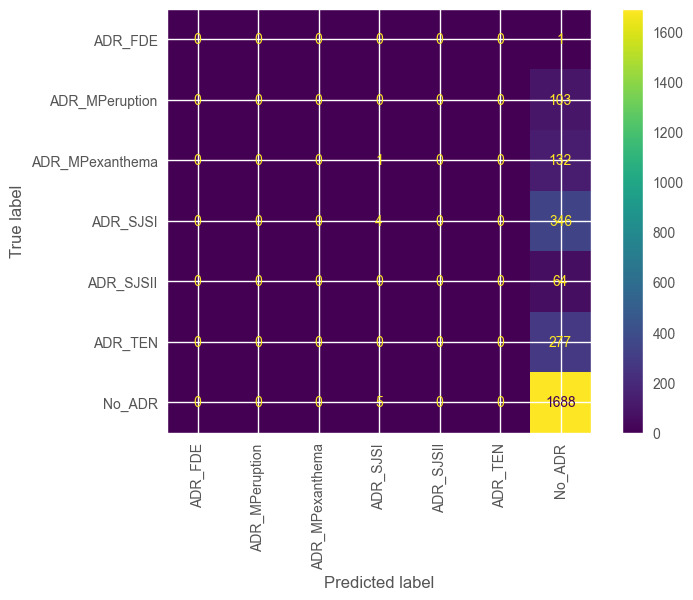

In [ ]:
classes = list(df_labels.columns)

#remove the value in list(df_labels.columns) that got the sum of 0 in df_labels.sum(0)
for x in list(df_labels.columns):
    if df_labels[x].sum(0) == 0:
        classes.remove(x)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(test_label[1], predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
disp.plot(xticks_rotation=90)
disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(test_label[1], predicted, target_names=classes)
print(cr)

                 precision    recall  f1-score   support

        ADR_FDE       0.00      0.00      0.00         1
 ADR_MPeruption       0.00      0.00      0.00       103
ADR_MPexanthema       0.00      0.00      0.00       133
       ADR_SJSI       0.40      0.01      0.02       350
      ADR_SJSII       0.00      0.00      0.00        64
        ADR_TEN       0.00      0.00      0.00       277
         No_ADR       0.65      1.00      0.78      1693

       accuracy                           0.65      2621
      macro avg       0.15      0.14      0.12      2621
   weighted avg       0.47      0.65      0.51      2621



c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

NameError: name 'allepoch_train_acc' is not defined

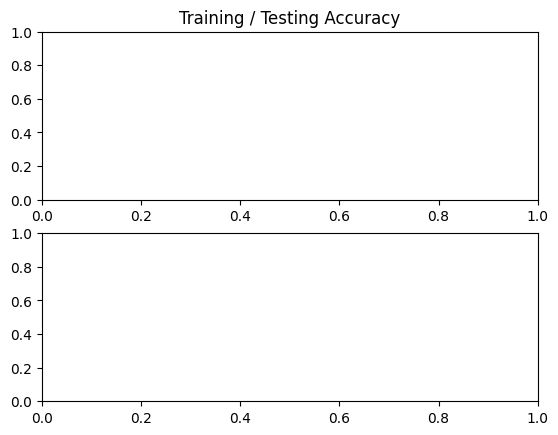

In [11]:
fig, ax = plt.subplots(2,1)
#plt.style.use('ggplot')

ax[0].set_title("Training / Testing Accuracy")
ax[0].plot(allepoch_train_acc, 'red',label='Train',marker='o')
ax[0].plot(allepoch_test_acc,'blue',label='Test',marker='o')
ax[0].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[0].set_ylabel("Accuracy")
ax[0].legend()
#ax[0].text(4,1,f"Model: {numberofmodel}")


ax[1].set_title("Training loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[1].set_ylabel("Loss")
ax[1].legend()
#plt.show()

plt.tight_layout()#h_pad = 3, w_pad=3)
plt.savefig(f"../4 - Training & Testing/models/model_{numberofmodel}.png")